In [1]:
!pip install pyLDAvis
!pip install pandas numpy chardet nltk scikit-learn gensim pyLDAvis matplotlib wordcloud

In [2]:
!pip install wordcloud

In [5]:
# 1. Set environment
import pandas as pd
import numpy as np
import chardet
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim import corpora, models
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YufeiCai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YufeiCai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YufeiCai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\YufeiCai\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
!pip install chardet
import chardet
with open(r"D:\CC\UoB\Social Media\期末作业\youtube_comments\数据处理preprocessing\数据处理preprocessing.csv", 'rb') as f:
    result = chardet.detect(f.read(10000))  
print(f"Detected encoding: {result['encoding']} (Confidence: {result['confidence']})")

Detected encoding: ISO-8859-1 (Confidence: 0.73)


In [9]:
# Upload dataset
df = pd.read_csv(r"D:\CC\UoB\Social Media\期末作业\youtube_comments\数据处理preprocessing\数据处理preprocessing.csv", 
                 encoding='ISO-8859-1')

In [11]:
print(df.head())
print(f"Total data volume: {len(df)}")
print("Top 5 translated comments:")
for i, comment in enumerate(df['Translated Comment'].head().values):
    print(f"{i+1}. {comment}")

                                  Translated Comment
0  Can it take me home from the pub without getti...
1                              teach it how to drift
2          This has to be one of the coolest robots.
3  Can you imagine what this will do for people w...
4  Yeah I just finished my 30 day trial of FSD an...
Total data volume: 4653
Top 5 translated comments:
1. Can it take me home from the pub without getting done for drink driving?
2. teach it how to drift
3. This has to be one of the coolest robots.
4. Can you imagine what this will do for people with disabilities someday. The freedom it would bring.
5. Yeah I just finished my 30 day trial of FSD and while it is decent, it still struggles a LOT. So much in fact that I can never truly relax. The other day it stopped right in the middle of a turn and just sat there so I took over because If i hadn't, accident waiting to happen. It needs a LOT more work and it is NOT Self-driving in the truest sense of the word. It struggles on 

#### **Data cleaning** ####

In [ ]:
#Data cleaning and translation quality check

# Remove duplicate values
print(f"Amount of original data: {len(df)}")
df = df.drop_duplicates(subset=['Translated Comment'])
print(f"Data volume after deduplication: {len(df)}")

# Handling missing values
print(f"Number of missing values: {df['Translated Comment'].isnull().sum()}")
df = df.dropna(subset=['Translated Comment'])

# Translation quality check function
def check_translation_quality(text):
    # Detect residual non-English characters (Chinese, Korean, Japanese character range)
    if re.search(r'[\u4e00-\u9fff\uac00-\ud7a3\u3040-\u309f\u30a0-\u30ff]', text):
        return False
    return True
    
# apply
df['Is_Translated'] = df['Translated Comment'].apply(check_translation_quality)
print(f"Number of suspected untranslated comments: {len(df[~df['Is_Translated']])}")

### **1. NLP Data Preparation** ###

#### **1.1 Remove noise** ####

In [21]:
# Custom stop word list (will be used in the LDA section)
custom_stopwords = set(stopwords.words('english')).union({
    'tesla', 'car', 'cars', 'vehicle', 'vehicles', 'self-driving', 'vidyakul','fsd',
    'autopilot', 'elon', 'musk', 'http', 'https', 'com', 'www','would','drive','model','driver'
})

def clean_text(text):
    # remove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove email
    text = re.sub(r'\S+@\S+', '', text)
    # remove number
    text = re.sub(r'\d+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]|_', ' ', text)
    # lowercase
    text = text.lower()
    return text

# apply
df['Cleaned_Text'] = df['Translated Comment'].apply(clean_text)

In [23]:
df['Cleaned_Text']

0       can it take me home from the pub without getti...
1                                   teach it how to drift
2               this has to be one of the coolest robots 
3       can you imagine what this will do for people w...
4       yeah i just finished my  day trial of fsd and ...
                              ...                        
4648    give uncle rich from rich rebuilds back his ac...
4649                                         pure garbage
4650                             i hit the dislike button
4651                 as fake as the cybertruck promotions
4652                                       the real trash
Name: Cleaned_Text, Length: 4508, dtype: object

#### **1.2 Lemmitation and Stemming** ####

In [26]:
# Word segmentation and lemmatization
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    # Lemmatization + Stemming
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    stemmed = [stemmer.stem(token) for token in tokens]
    # Remove stop words
    filtered_lemmatized = [word for word in lemmatized if word not in custom_stopwords]
    filtered_stemmed = [word for word in stemmed if word not in custom_stopwords]
    return {
        'lemmatized': filtered_lemmatized,
        'stemmed': filtered_stemmed
    }

In [28]:
# apply
text_processing = df['Cleaned_Text'].apply(preprocess_text)
df['Lemmatized_Tokens'] = text_processing.apply(lambda x: x['lemmatized'])
df['Stemmed_Tokens'] = text_processing.apply(lambda x: x['stemmed'])

In [29]:
df['Lemmatized_Tokens'] 

0       [take, home, pub, without, getting, done, drin...
1                                          [teach, drift]
2                               [ha, one, coolest, robot]
3       [imagine, people, disability, someday, freedom...
4       [yeah, finished, day, trial, decent, still, st...
                              ...                        
4648    [give, uncle, rich, rich, rebuilds, back, acco...
4649                                      [pure, garbage]
4650                               [hit, dislike, button]
4651                        [fake, cybertruck, promotion]
4652                                        [real, trash]
Name: Lemmatized_Tokens, Length: 4508, dtype: object

In [30]:
df['Stemmed_Tokens']

0            [take, home, pub, without, get, done, drink]
1                                          [teach, drift]
2                          [thi, ha, one, coolest, robot]
3       [imagin, thi, peopl, disabl, someday, freedom,...
4       [yeah, finish, day, trial, decent, still, stru...
                              ...                        
4648    [give, uncl, rich, rich, rebuild, back, hi, ac...
4649                                       [pure, garbag]
4650                                [hit, dislik, button]
4651                           [fake, cybertruck, promot]
4652                                        [real, trash]
Name: Stemmed_Tokens, Length: 4508, dtype: object

#### **1.3 VADER automatically generates sentiment labels** ####

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
# download VADER vocabulary
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\YufeiCai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Sentiment label distribution:
sentiment_label
positive    40.6%
neutral     38.3%
negative    21.1%
Name: proportion, dtype: object


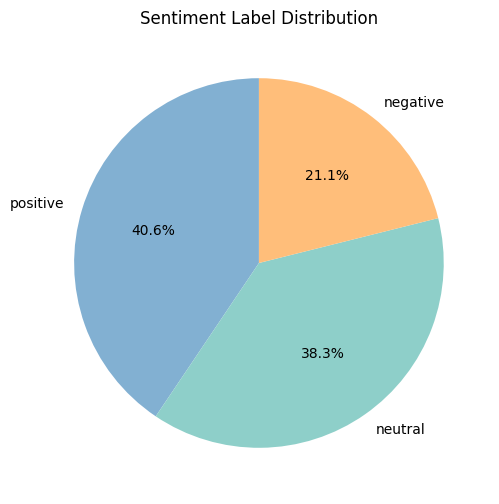

In [37]:
sia = SentimentIntensityAnalyzer()

# Generate sentiment score (range: -1 to 1)
df['sentiment_score'] = df['Cleaned_Text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

# Define the label division threshold
thresholds = {
    'negative': (-1.0, -0.05),
    'neutral': (-0.05, 0.05),
    'positive': (0.05, 1.0)
}

# Generate text labels and numerical labels
df['sentiment_label'] = np.select(
    condlist=[
        df['sentiment_score'] < -0.05,
        df['sentiment_score'] > 0.05
    ],
    choicelist=['negative', 'positive'],
    default='neutral'
)

# Convert to numeric labels (negative=0, neutral=1, positive=2)
label_mapping = {'negative':0, 'neutral':1, 'positive':2}
df['label'] = df['sentiment_label'].map(label_mapping)


print("Sentiment label distribution:")
print(df['sentiment_label'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Visualize the distribution
plt.figure(figsize=(8,6))
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#82B0D2','#8ECFC9','#FFBE7A'],
    startangle=90
)
plt.title('Sentiment Label Distribution')
plt.ylabel('')
plt.show()

In [39]:
#Tag cleaning
# Remove missing tags caused by empty text
df = df[df['Cleaned_Text'].str.strip().astype(bool)].copy()

# Ensure label column is valid
assert df['sentiment_label'].isin(['negative', 'neutral', 'positive']).all(), "There are illegal emotional tags"
df['label'] = df['sentiment_label'].map(label_mapping)

print("The number of missing label values ​​after processing:", df['label'].isna().sum())
assert df['label'].isna().sum() == 0, "There are still unprocessed missing tags"

The number of missing label values ​​after processing: 0


#### **1.4 Vectorize** ####

In [47]:
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD

In [49]:
# Data partitioning
lemmatized_texts = [' '.join(tokens) for tokens in df['Lemmatized_Tokens']]
y = df['label'].values  

# Layered division
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    lemmatized_texts, 
    y,
    np.arange(len(y)), 
    test_size=0.3,
    stratify=y,
    random_state=42
)

#### **Compare model performance of BoW,TF-IDF,Word2Vec** ####

In [52]:
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight

Training Word2Vec model...
Generating document vectors...
Applying dimensionality reduction...

Starting vectorizer comparison...

Processing BoW...

Processing TF-IDF...

Processing Word2Vec...


,BoW,TF-IDF,Word2Vec+SVD
LR,0.759287,0.75260,0.550520
NB,0.626300,0.63893,0.476969


<Figure size 1000x800 with 0 Axes>

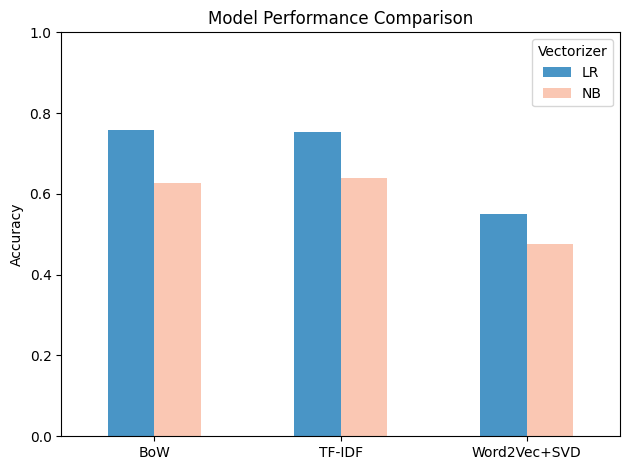

In [54]:
def text_to_avg_vec(tokens, model, vector_size=100):
    #Convert word list to average word vector
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec

def train_word2vec(train_tokens):
    #Training the Word2Vec model
    return Word2Vec(
        sentences=train_tokens,
        vector_size=100,
        window=5,
        min_count=10,
        workers=4,
        epochs=20,
        seed=42
    )

def generate_w2v_vectors(tokens_list, model):
    return np.array([text_to_avg_vec(tokens, model) for tokens in tokens_list])


# Get word lemmatization data
train_tokens = df.iloc[train_index]['Lemmatized_Tokens'].tolist()
test_tokens = df.iloc[test_index]['Lemmatized_Tokens'].tolist()

# train Word2Vec model
print("Training Word2Vec model...")
w2v_model = train_word2vec(train_tokens)

# Generate document vectors
print("Generating document vectors...")
w2v_vectors_train = generate_w2v_vectors(train_tokens, w2v_model)
w2v_vectors_test = generate_w2v_vectors(test_tokens, w2v_model)

# Dimensionality reduction
print("Applying dimensionality reduction...")
svd = TruncatedSVD(n_components=50, random_state=42)
w2v_vectors_train_reduced = svd.fit_transform(w2v_vectors_train)
w2v_vectors_test_reduced = svd.transform(w2v_vectors_test)


global_models = {
    'BoW': {'LR': None, 'NB': None, 'X_test': None},
    'TF-IDF': {'LR': None, 'NB': None, 'X_test': None},
    'Word2Vec+SVD': {'LR': None, 'NB': None, 'X_test': None}
}

def compare_vectorizers():
    results = {}
    
    # ==========  BoW Processing ==========
    print("\nProcessing BoW...")
    bow_vectorizer = CountVectorizer(max_features=1000)
    X_train_bow = bow_vectorizer.fit_transform(X_train)
    X_test_bow = bow_vectorizer.transform(X_test)
    
    # Train the model and save it
    lr_bow = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_bow, y_train)
    nb_bow = MultinomialNB().fit(X_train_bow, y_train)
    global_models['BoW']['LR'] = lr_bow
    global_models['BoW']['NB'] = nb_bow
    global_models['BoW']['X_test'] = X_test_bow
    
    # Collecte Results
    results['BoW'] = {
        'LR': accuracy_score(y_test, lr_bow.predict(X_test_bow)),
        'NB': accuracy_score(y_test, nb_bow.predict(X_test_bow))
    }
    
    # ==========  TF-IDF ==========
    print("\nProcessing TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    # Train the model and save it
    lr_tfidf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_tfidf, y_train)
    nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
    global_models['TF-IDF']['LR'] = lr_tfidf
    global_models['TF-IDF']['NB'] = nb_tfidf
    global_models['TF-IDF']['X_test'] = X_test_tfidf
    
    # Collecte Results
    results['TF-IDF'] = {
        'LR': accuracy_score(y_test, lr_tfidf.predict(X_test_tfidf)),
        'NB': accuracy_score(y_test, nb_tfidf.predict(X_test_tfidf))
    }
    
    # ========== Word2Vec==========
    print("\nProcessing Word2Vec...")
    lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
    lr_w2v.fit(w2v_vectors_train_reduced, y_train)
    nb_w2v = GaussianNB()
    nb_w2v.fit(w2v_vectors_train_reduced, y_train)
    
    global_models['Word2Vec+SVD']['LR'] = lr_w2v
    global_models['Word2Vec+SVD']['NB'] = nb_w2v
    global_models['Word2Vec+SVD']['X_test'] = w2v_vectors_test_reduced
    
    # Collecte Results
    results['Word2Vec+SVD'] = {
        'LR': accuracy_score(y_test, lr_w2v.predict(w2v_vectors_test_reduced)),
        'NB': accuracy_score(y_test, nb_w2v.predict(w2v_vectors_test_reduced))
    }
    
    return pd.DataFrame(results)

# apply comparison
print("\nStarting vectorizer comparison...")
vectorizer_comparison = compare_vectorizers()
display(vectorizer_comparison)

# Visualize the results
plt.figure(figsize=(10,8))
color_mapping = {
    'LR': '#4995C6',  
    'NB': '#FAC7B3'   
}

models = vectorizer_comparison.index.tolist()  
colors = [color_mapping[model] for model in models]
vectorizer_comparison.T.plot(
    kind='bar',
    rot=0,
    color=colors  
)

plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(title='Vectorizer', bbox_to_anchor=(1, 1))  
plt.tight_layout()
plt.show()

### **2. Sentiment Analysis** ###

In [57]:
!pip install seaborn

In [64]:
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from PIL import Image

#### **2.1 Wordcloud** ####

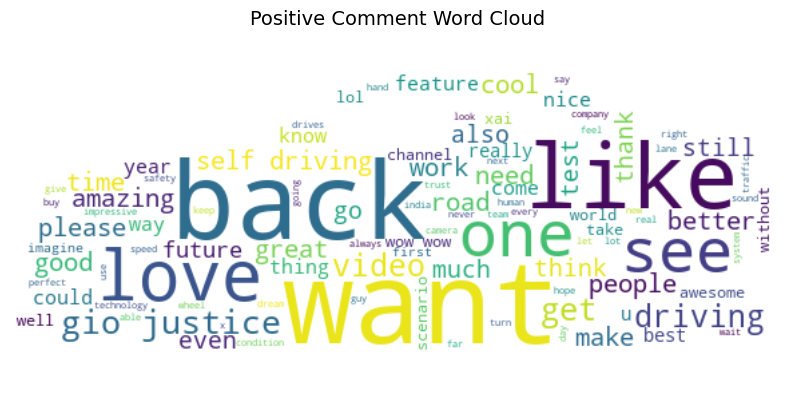

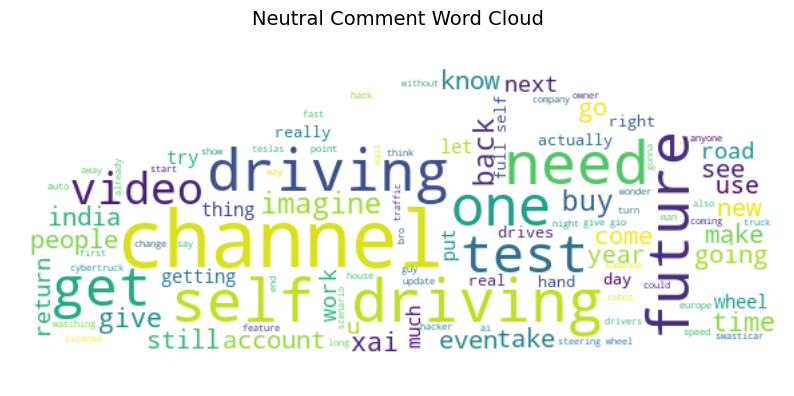

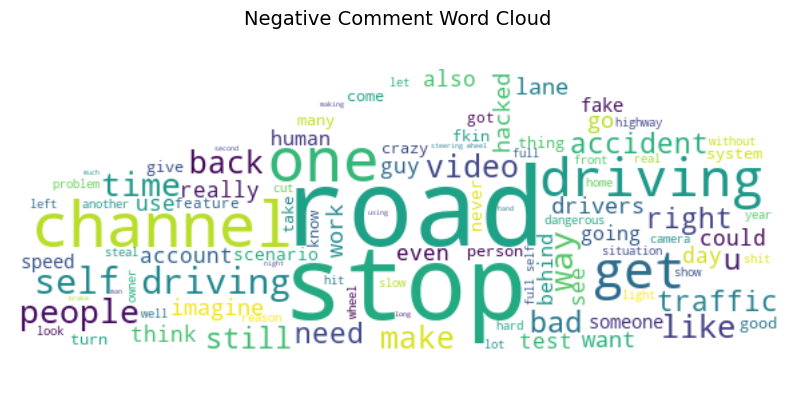

In [66]:
# upload car picture
car_mask_path = r"D:\CC\UoB\Social Media\期末作业\youtube_comments\数据处理preprocessing\car.png"
car_mask = np.array(Image.open(car_mask_path))

def generate_emotion_wordcloud(sentiment_label):
    # Generate a car shape word cloud 
    text = ' '.join(df[df['sentiment_label'] == sentiment_label]['Cleaned_Text'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100,
        mask=car_mask,          
        contour_width=0,
        contour_color='black'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment_label.capitalize()} Comment Word Cloud', fontsize=14)
    plt.axis('off')
    plt.show()

# Generate three types of word clouds
for label in ['positive', 'neutral', 'negative']:
    generate_emotion_wordcloud(label)

#### **Confusion Matrix** ####

<Figure size 800x600 with 0 Axes>

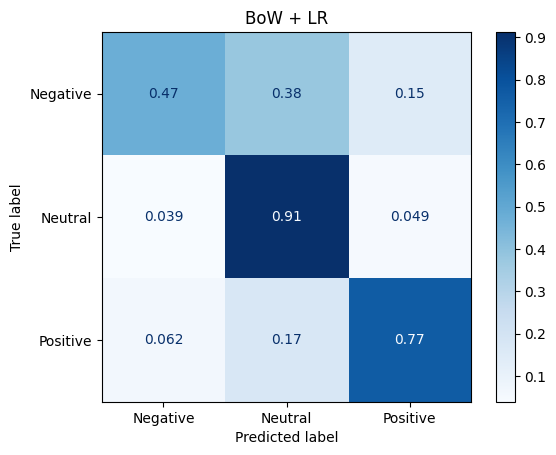

<Figure size 800x600 with 0 Axes>

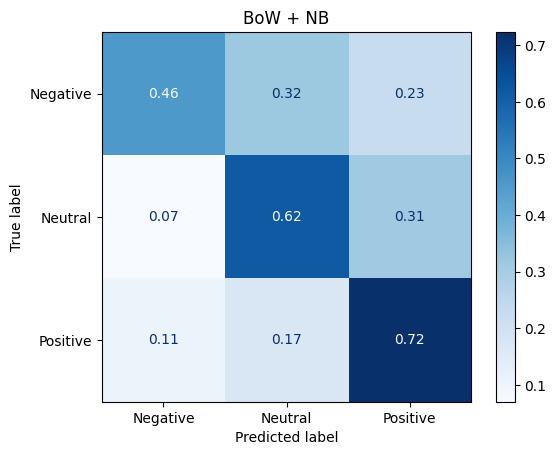

<Figure size 800x600 with 0 Axes>

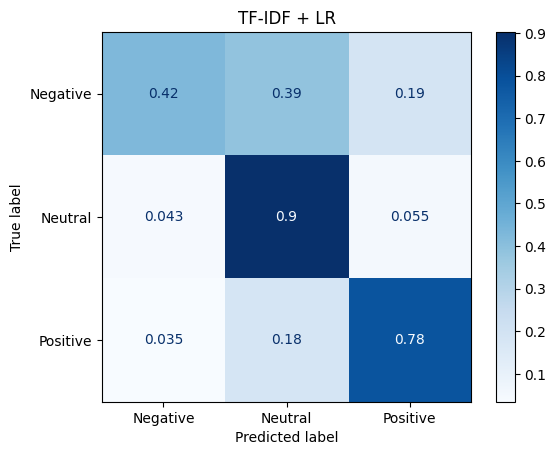

<Figure size 800x600 with 0 Axes>

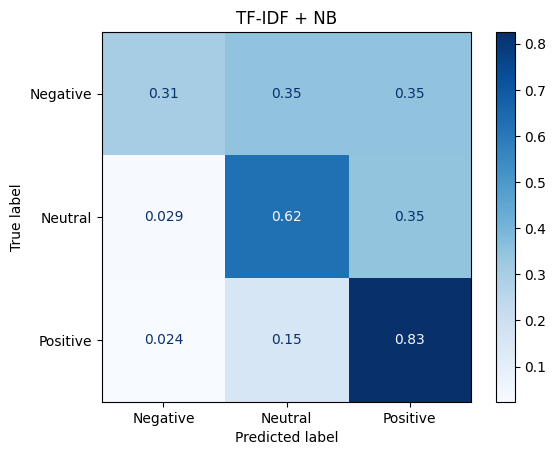

<Figure size 800x600 with 0 Axes>

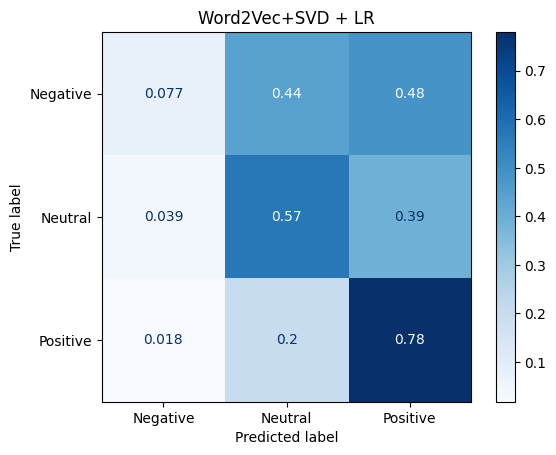

<Figure size 800x600 with 0 Axes>

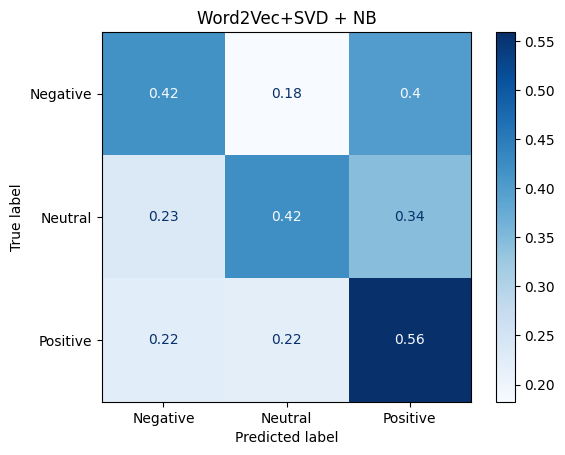

In [72]:
def plot_confusion_matrix(method, classifier):
    
    model = global_models[method][classifier]
    X_test = global_models[method]['X_test']
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    plt.figure(figsize=(8,6))
    ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive']).plot(cmap='Blues')
    plt.title(f'{method} + {classifier}', fontsize=12)
    plt.show()

# Generate confusion matrix for all combinations
plot_confusion_matrix('BoW', 'LR')
plot_confusion_matrix('BoW', 'NB')
plot_confusion_matrix('TF-IDF', 'LR')
plot_confusion_matrix('TF-IDF', 'NB')
plot_confusion_matrix('Word2Vec+SVD', 'LR')
plot_confusion_matrix('Word2Vec+SVD', 'NB')

### **3. Topic modeling (LDA)** ###

In [69]:
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
import numpy as np

=== Positive Comments Analysis ===


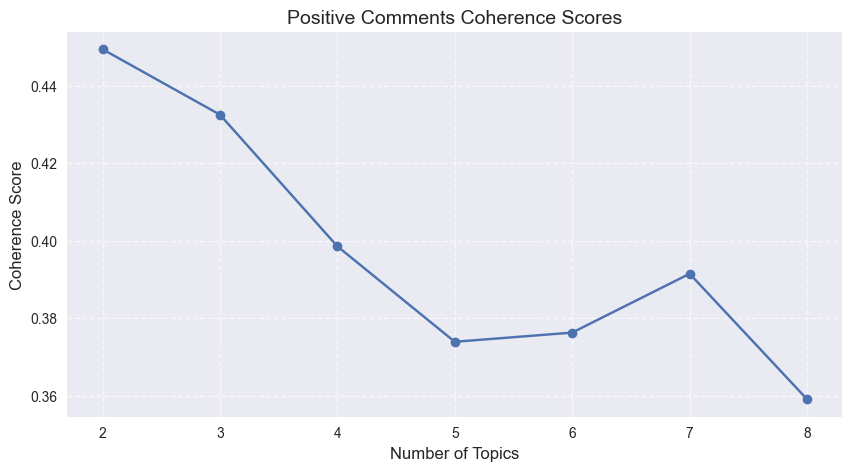

Optimal topics for positive: 2 (Coherence: 0.449)
Saved interactive distance map for 2 topics as lda_positive_2_distance_map.html
Saved interactive distance map for 3 topics as lda_positive_3_distance_map.html
Saved interactive distance map for 4 topics as lda_positive_4_distance_map.html


<Figure size 1200x800 with 0 Axes>

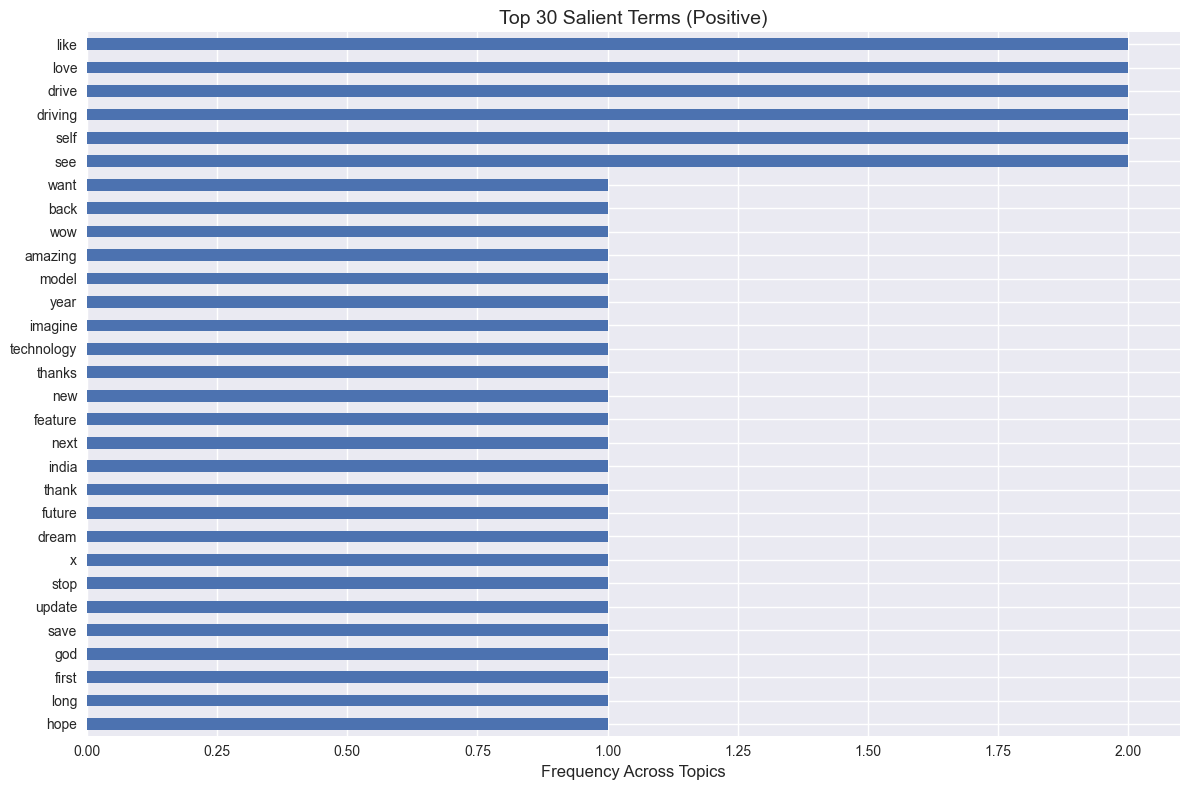


=== Negative Comments Analysis ===


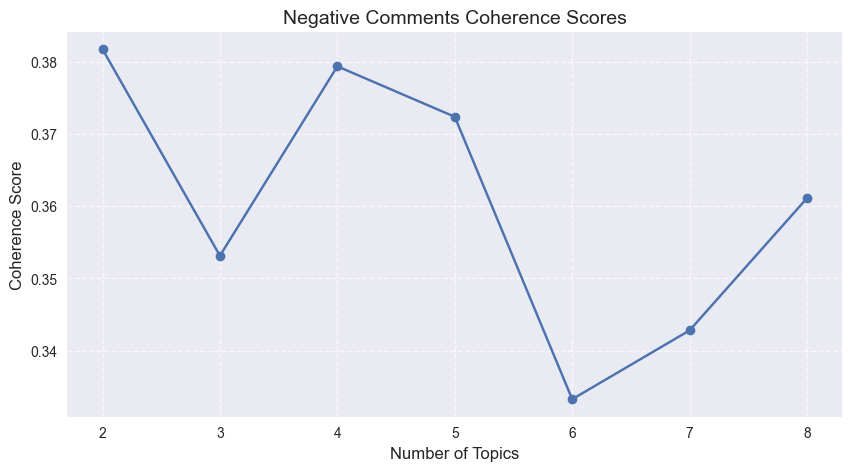

Optimal topics for negative: 2 (Coherence: 0.382)
Saved interactive distance map for 2 topics as lda_negative_2_distance_map.html
Saved interactive distance map for 4 topics as lda_negative_4_distance_map.html
Saved interactive distance map for 5 topics as lda_negative_5_distance_map.html


<Figure size 1200x800 with 0 Axes>

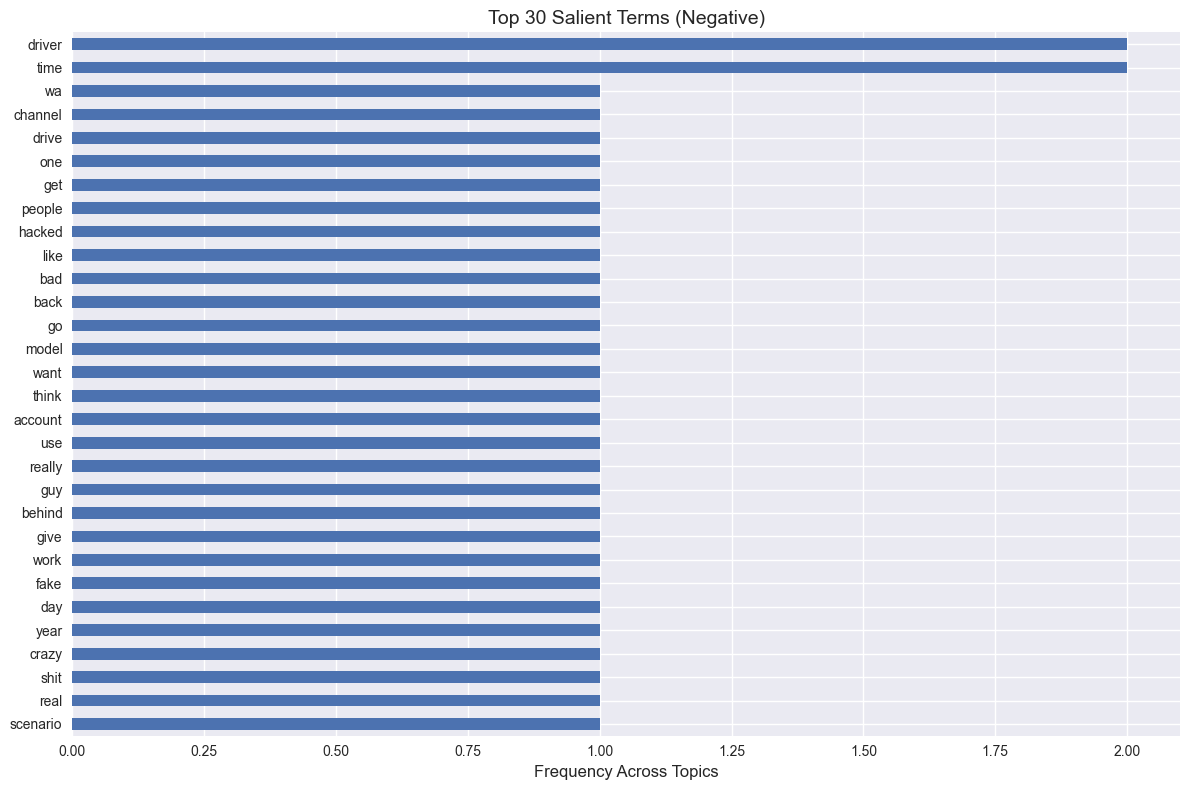

In [65]:
import numpy as np
plt.style.use('seaborn-v0_8')

# Subdataset preparation
pos_comments = df[df['sentiment_label'] == 'positive']
neg_comments = df[df['sentiment_label'] == 'negative']
neu_comments = df[df['sentiment_label'] == 'neutrual']

def optimize_lda(subset_df, sentiment_label, start=2, end=8):
    
    # Optimize the number of LDA topics by sentiment
    texts = subset_df['Lemmatized_Tokens'].tolist()
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # coherence_value evaluation
    coherence_values = []
    models = []
    for n_topics in range(start, end+1):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=n_topics,
            random_state=42,
            passes=15
        )
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
        models.append(model)
    
    # Consistency curve evaluation
    plt.figure(figsize=(10,5))
    plt.plot(range(start, end+1), coherence_values, marker='o')
    plt.title(f'{sentiment_label.capitalize()} Comments Coherence Scores', fontsize=14)
    plt.xlabel("Number of Topics", fontsize=12)
    plt.ylabel("Coherence Score", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()
    
    # Selecting the best model
    optimal_idx = np.argmax(coherence_values)
    optimal_model = models[optimal_idx]
    print(f"Optimal topics for {sentiment_label}: {start + optimal_idx} (Coherence: {coherence_values[optimal_idx]:.3f})")
        
    # Interactive Topic Distance Map
    # Get the indexes sorted in descending order by consistency score and take the top 3
    top_indices = np.argsort(coherence_values)[::-1][:3]
    for idx in top_indices:
        n_topics = start + idx
        model = models[idx]
        vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
        filename = f'lda_{sentiment_label}_{n_topics}_distance_map.html'
        pyLDAvis.save_html(vis, filename)
        print(f"Saved interactive distance map for {n_topics} topics as {filename}")
    
    # Significant topic words analysis (first 30)
    topic_keywords = []
    for topic_id in range(optimal_model.num_topics):
        keywords = optimal_model.show_topic(topic_id, topn=30)
        topic_keywords.extend([word for word, _ in keywords])
    
    from collections import Counter
    word_freq = Counter(topic_keywords)
    
    plt.figure(figsize=(12,8))
    import pandas as pd


    top_words = word_freq.most_common(30)[::-1]
    top_words_series = pd.Series(dict(top_words))
    
    plt.figure(figsize=(12,8))
    top_words_series.plot(kind='barh')  
    plt.title(f'Top 30 Salient Terms ({sentiment_label.capitalize()})', fontsize=14)
    plt.xlabel('Frequency Across Topics', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return optimal_model

# apply (sample range 2-8 topics)
print("=== Positive Comments Analysis ===")
pos_lda = optimize_lda(pos_comments, 'positive', start=2, end=8)

print("\n=== Negative Comments Analysis ===")
neg_lda = optimize_lda(neg_comments, 'negative', start=2, end=8)